In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import argparse

In [2]:
# [2] Reward loading function
def load_rewards(npz_file):
    """Load rewards data from npz file"""
    data = np.load(npz_file, allow_pickle=True)
    rewards = data['rewards']
    moving_avg = data['moving_avg_100']
    config = json.loads(str(data['config']))  # Convert from numpy string to dict
    return rewards, moving_avg, config

In [20]:
def plot_multiple_rewards(result_dirs, save_path=None, window_size=100):
    """Plot multiple reward curves on the same plot
    
    Args:
        result_dirs (list): List of directories containing reward.npz files
        save_path (str, optional): Where to save the plot. If None, displays it
        window_size (int): Window size for moving average if not pre-computed
    """
    plt.figure(figsize=(12, 8))
    
    for result_dir in result_dirs:
        path = Path(result_dir)
        rewards_file = path / "rewards.npz"
        
        if not rewards_file.exists():
            print(f"Warning: No rewards.npz found in {result_dir}")
            continue
            
        rewards, moving_avg, config = load_rewards(rewards_file)
        
        # Create label from config
        label = f"lr={config['lr']}"
        
        # Add noise details
        noise_type = config.get('noise_type', 'normal')
        label += f"_noise={noise_type}"
        if noise_type == 'ornstein':
            label += f"(θ={config['noise_theta']},σ={config['noise_sigma']})"
        elif noise_type == 'colored':
            label += f"(β={config['noise_beta']},σ={config['noise_sigma']})"
        elif noise_type in ['normal', 'pink']:
            label += f"(σ={config['noise_sigma']})"
        
        # Add PER details if enabled
        if config['use_per']:
            label += f"_PER(α={config['per_alpha']},β={config['per_beta']})"
            
        # Add ERE details if enabled
        if config['use_ere']:
            label += f"_ERE(η={config['ere_eta0']})"
            
        # Add loss type
        label += f"_loss={config['loss_type']}"
        
        # Plot moving average
        if len(moving_avg) > 0:
            plt.plot(moving_avg, label=label)
        else:
            # If moving average wasn't pre-computed, compute it now
            moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
            plt.plot(moving_avg, label=label)
    
    plt.title(f"Training Rewards Comparison (Moving Avg {window_size} episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend(bbox_to_anchor=(0.9, 0.5), loc='upper right', borderaxespad=0.)
    plt.grid(True, alpha=0.3)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

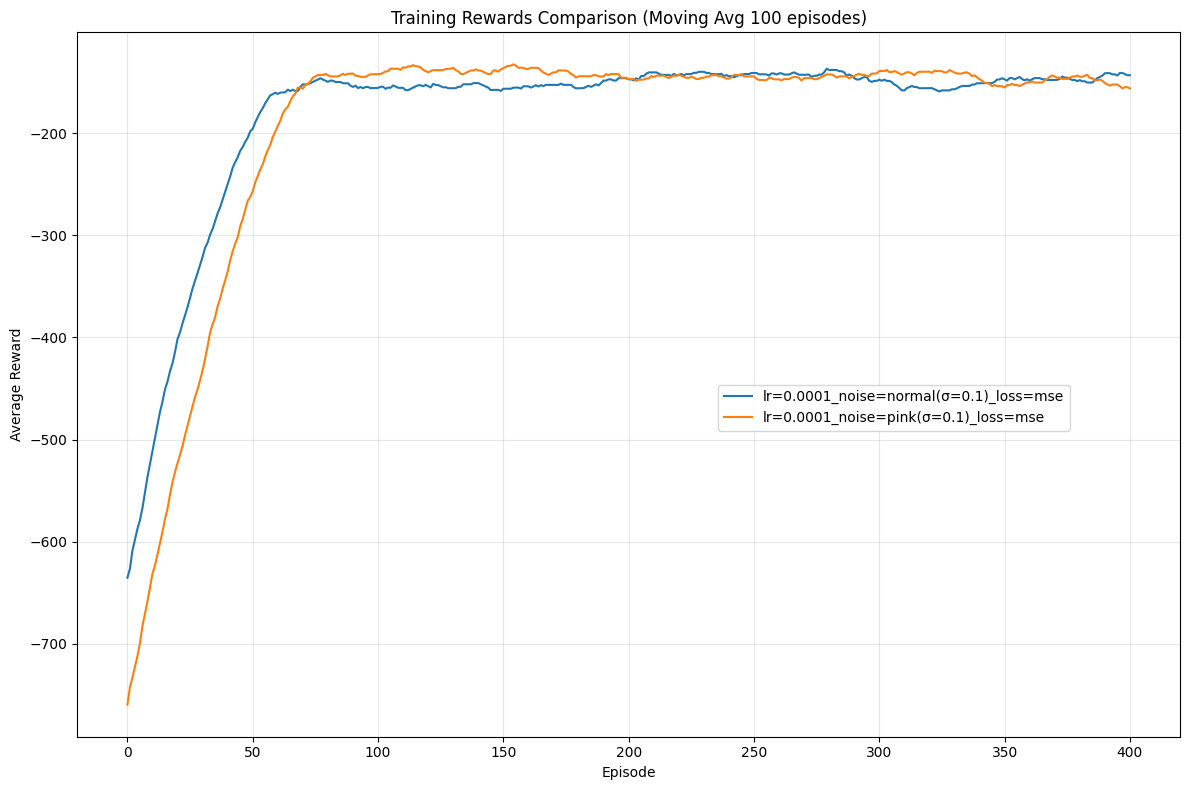

In [22]:
# [4] Example usage
# List your result directories
result_dirs = [
    "./results/SAC-env_Pendulum-v1-lr_0.0001-seed_7-20250103_164334",
    "./results/SAC-env_Pendulum-v1-lr_0.0001-seed_7-20250103_172806",
    #"./results/SAC-env_Pendulum-v1-lr_0.0001-seed_7-20250103_174219",
    # "./results/SAC-env_Pendulum-v1-lr_0.0001-seed_7-20250103_174700"
    # Add more directories as needed
]

# Plot rewards
plot_multiple_rewards(result_dirs, window_size=100)